In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [32]:
# Load train and Test set
train = pd.read_csv('Train.csv.zip', compression='zip')
test = pd.read_csv('Test.csv.zip', compression='zip')

# train['price'] = train['price'] / 1000

In [33]:
# Check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

# Save the 'Id' column
train_ID = train['id']
test_ID = test['id']

# Now drop the 'Id' column since it's unnecessary for the prediction process.
train.drop("id", axis = 1, inplace = True)
test.drop("id", axis = 1, inplace = True)

# Check data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (100000, 25) 
The test data size before dropping Id feature is : (100000, 24) 

The train data size after dropping Id feature is : (100000, 24) 
The test data size after dropping Id feature is : (100000, 23) 


In [34]:
train.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,2011-01-01,164,1.0,5,50,2,1,20.0,0.0,3,...,0,0,0,0,0,0,0,0,0,3947000
1,2011-01-01,66,NaN,5,48,2,0,20.0,NaN,0,...,0,0,0,0,0,0,0,0,0,2525000
2,2011-01-01,642,2.0,21,61,2,0,10.0,0.0,0,...,0,0,0,0,0,0,0,0,0,19984000
3,2011-01-01,562,1.0,11,95,3,1,10.0,NaN,2,...,0,0,0,0,0,0,0,0,0,9727000
4,2011-01-01,151,NaN,9,34,1,0,20.0,NaN,2,...,0,0,0,0,0,0,0,0,0,2662000


In [35]:
test.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,2012-06-01,459,NaN,6,48,2,0,15.0,1.0,2,...,0,0,0,0,0,0,0,0,0,0
1,2012-06-01,403,0.0,6,32,1,0,10.0,NaN,1,...,0,0,0,0,0,0,0,0,0,0
2,2012-06-01,405,NaN,9,46,2,0,15.0,0.0,2,...,0,0,0,0,0,0,0,0,0,0
3,2012-06-01,314,2.0,10,44,1,0,15.0,NaN,7,...,0,0,0,0,0,0,0,0,0,0
4,2012-06-01,661,0.0,1,47,2,0,20.0,0.0,3,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# Getting Description
train['price'].describe()

count    1.000000e+05
mean     4.709459e+06
std      3.969739e+06
min      4.570000e+05
25%      2.384000e+06
50%      3.739000e+06
75%      5.700000e+06
max      8.356700e+07
Name: price, dtype: float64


 mu = 4709459.10 and sigma = 3969718.91



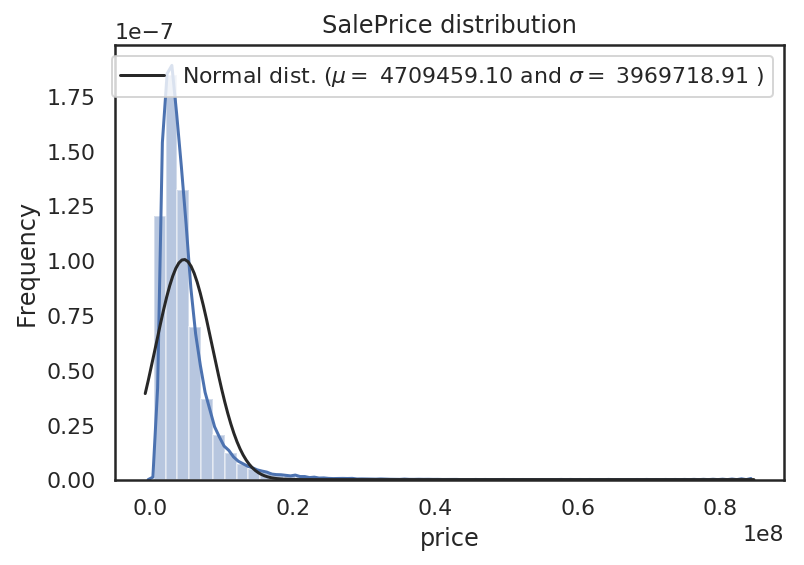

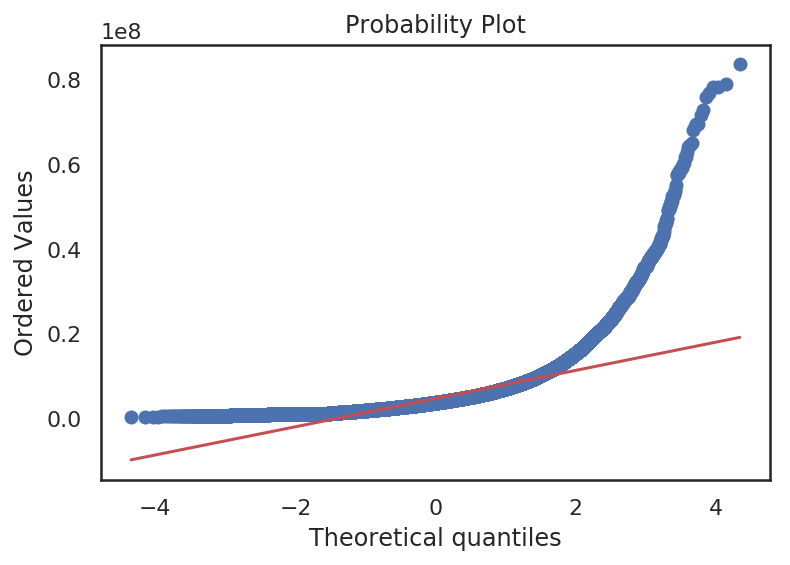

Skewness: 4.075253
Kurtosis: 34.446583


In [37]:
# Plot Histogram
sns.distplot(train['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()

print("Skewness: %f" % train['price'].skew())
print("Kurtosis: %f" % train['price'].kurt())

In [38]:
# Checking Categorical Data
train.select_dtypes(include=['object']).columns

Index(['date'], dtype='object')

In [39]:
# Checking Numerical Data
train.select_dtypes(include=['int64','float64']).columns

Index(['street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon',
       'metro_dist', 'g_lift', 'n_photos', 'kw1', 'kw2', 'kw3', 'kw4', 'kw5',
       'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13', 'price'],
      dtype='object')

In [40]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  1 categorical + 23 numerical = 24 features


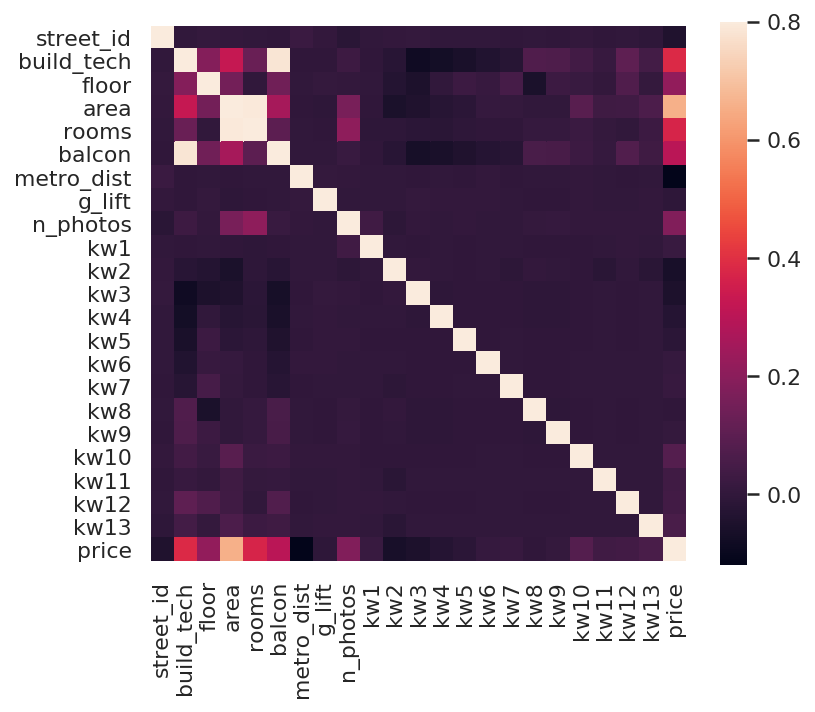

In [41]:
# Correlation Matrix Heatmap
corrmat = train.corr()
f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(corrmat, vmax=.8, square=True);

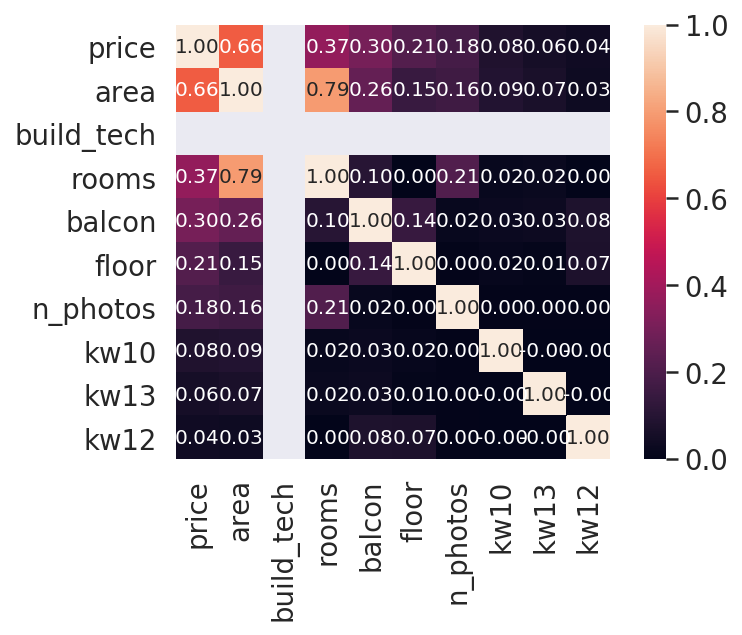

In [42]:
# Top 10 Heatmap
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [43]:
# По итогам анализа данных:
# - можно удалить столбец metro_dist - он слабо коррелирует с целевой переменной - price
# - можно удалить 3 строки из n_photos - хотя они зависимость отражают все таки

# вообщем это можно потом попробовать сделать..

In [45]:
# Combining Datasets
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.price.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['price'], axis=1, inplace=True)
print("Train data size is : {}".format(train.shape))
print("Test data size is : {}".format(test.shape))
print("Combined dataset size is : {}".format(all_data.shape))

Train data size is : (100000, 24)
Test data size is : (100000, 23)
Combined dataset size is : (200000, 23)


In [46]:
# Find Missing Ratio of Dataset
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
build_tech,29.9565
g_lift,29.8705
metro_dist,4.9310


In [47]:
# NaN build_tech заменим на 0,5 - так как 0,0 и 0,1 ~ 30 000, а 2,0 - всего 2 000 и в трейне и в тесте (можно попробовать потом категориальный сделать)
all_data["build_tech"] = all_data["build_tech"].fillna(0.5)

In [48]:
# g_lift - дропним, мало того что никакой корреляции, так еще и NaN
all_data.drop("g_lift", axis = 1, inplace = True)

In [49]:
# metro_dist - заполним медианным значением
all_data["metro_dist"] = all_data["metro_dist"].fillna(15.0)

In [50]:
# уберем плохо коррелирующие признаки
all_data.drop("kw2", axis = 1, inplace = True)
all_data.drop("kw3", axis = 1, inplace = True)
all_data.drop("kw4", axis = 1, inplace = True)
all_data.drop("kw5", axis = 1, inplace = True)
all_data.drop("kw6", axis = 1, inplace = True)
all_data.drop("kw7", axis = 1, inplace = True)
all_data.drop("kw8", axis = 1, inplace = True)
all_data.drop("kw9", axis = 1, inplace = True)

In [51]:
# Check if there are any missing values left
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [52]:
# делаем признаки котегориальными
all_data['date'] = all_data['date'].astype(str)
all_data['street_id'] = all_data['street_id'].astype(str)
all_data['kw10'] = all_data['kw10'].astype(str)
all_data['kw11'] = all_data['kw11'].astype(str)
all_data['kw12'] = all_data['kw12'].astype(str)
all_data['kw13'] = all_data['kw13'].astype(str)
all_data['kw1'] = all_data['kw1'].astype(str)

In [53]:
all_data
all_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 14 columns):
area          200000 non-null int64
balcon        200000 non-null int64
build_tech    200000 non-null float64
date          200000 non-null object
floor         200000 non-null int64
kw1           200000 non-null object
kw10          200000 non-null object
kw11          200000 non-null object
kw12          200000 non-null object
kw13          200000 non-null object
metro_dist    200000 non-null float64
n_photos      200000 non-null int64
rooms         200000 non-null int64
street_id     200000 non-null object
dtypes: float64(2), int64(5), object(7)
memory usage: 21.4+ MB


In [23]:
# подумай об инжиринге фич, типа площадь комнаты для однушки


 mu = 15.13 and sigma = 0.68



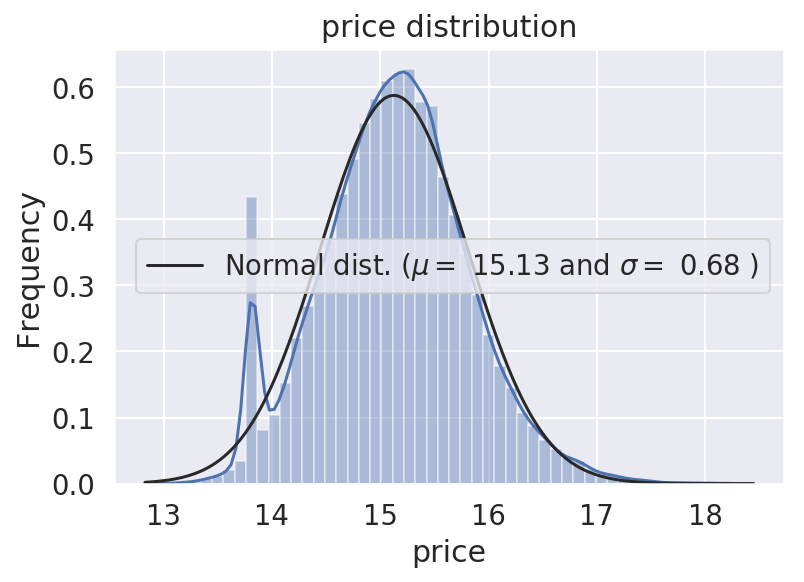

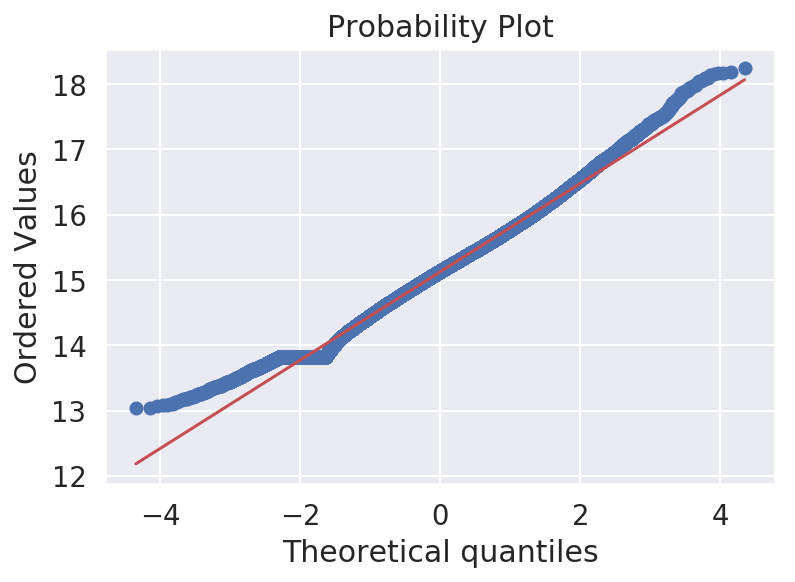

Skewness: 0.127139
Kurtosis: 0.122251


In [54]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["price"] = np.log1p(train["price"])

#Check the new distribution 
sns.distplot(train['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('price distribution')

fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()

y_train = train.price.values

print("Skewness: %f" % train['price'].skew())
print("Kurtosis: %f" % train['price'].kurt())

# а с этим нужно что-то делать?

In [57]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness

,Skewed Features
area,3.050215
floor,1.665184
balcon,0.954434
build_tech,0.665679
n_photos,0.567549
rooms,0.055912
metro_dist,-0.615003


In [59]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    all_data[feat] += 1

There are 7 skewed numerical features to Box Cox transform


In [60]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(200000, 725)


In [61]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [62]:
train.head()

,area,balcon,build_tech,floor,metro_dist,n_photos,rooms,date_2011-01-01,date_2011-02-01,date_2011-03-01,...,street_id_90,street_id_91,street_id_92,street_id_93,street_id_94,street_id_95,street_id_96,street_id_97,street_id_98,street_id_99
0,3.326562,2.084092,2.084092,2.557988,3.024541,2.392255,2.268672,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.313317,1.730463,1.944102,2.557988,3.024541,1.730463,2.268672,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.390791,1.730463,2.268672,3.040854,2.790983,1.730463,2.268672,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.532177,2.084092,2.084092,2.823219,2.790983,2.268672,2.392255,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.200623,1.730463,1.944102,2.755352,3.024541,2.268672,2.084092,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# 6. Modeling and Predictions

In [63]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [64]:
# Cross-validation with k-folds
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [65]:
# For our models, we are going to use lasso, elastic net, kernel ridge, gradient boosting, XGBoost, and LightGBM regression.

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state =7)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [70]:
# Checking performance of base models by evaluating the cross-validation RMSLE error.

score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# score = rmsle_cv(KRR)
# print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.4185 (0.0024)

ElasticNet score: 0.4100 (0.0025)



In [71]:
# score = rmsle_cv(GBoost)
# print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

GBoost.predict(test)

NotFittedError: This GradientBoostingRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))